# Frequency correlation plots

Example code for how to calculate frequency correlation plots from augur forecasting builds.

In [1]:
import altair as alt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

In [2]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [3]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["frequency_final"] > freq_df["frequency"])
        predicted_growth = (freq_df["projected_frequency"] > freq_df["frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["frequency_final"] <= freq_df["frequency"])
        predicted_decline = (freq_df["projected_frequency"] <= freq_df["frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [4]:
data_root = "../results/builds/simulated/simulated_sample_0/"

In [5]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [6]:
tips.head(1)

,strain,timepoint,frequency
0,sample_1092_1,2011-10-01,0.000001


In [7]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root, sep="\t", parse_dates=["timepoint"])

In [8]:
tips_to_clades.head(1)

,tip,clade_membership,depth,timepoint
0,sample_1016_4,6657900,0,2011-10-01


In [9]:
forecasts = pd.read_csv(
    "%s/simulated_sample_0_lbi_forecast.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "fitness", "frequency", "projected_frequency"]
)

In [10]:
forecasts.head(1)

,timepoint,strain,frequency,fitness,projected_frequency
0,2011-10-01,sample_1092_1,0.000001,-10.084649,7.927373e-14


## Find large clades

Find all clades with an initial frequency some minimum value (e.g., >15%).

In [60]:
clade_tip_initial_frequencies = tips_to_clades.merge(
    tips,
    how="left",
    left_on=["timepoint", "tip"],
    right_on=["timepoint", "strain"]
).drop(columns=["depth", "strain"])

In [61]:
clade_tip_initial_frequencies.head()

,tip,clade_membership,timepoint,frequency
0,sample_1016_4,6657900,2011-10-01,NaN
1,sample_1016_4,bf3c018,2011-10-01,NaN
2,sample_1016_4,root,2011-10-01,NaN
3,sample_1008_3,7a6369f,2011-10-01,NaN
4,sample_1008_3,bf3c018,2011-10-01,NaN


In [66]:
clade_tip_initial_frequencies = clade_tip_initial_frequencies.fillna(0.0).copy()

In [67]:
pd.isnull(clade_tip_initial_frequencies["frequency"]).sum()

0

In [68]:
initial_clade_frequencies = clade_tip_initial_frequencies.groupby(["timepoint", "clade_membership"])["frequency"].sum().reset_index()

In [69]:
initial_clade_frequencies.head()

,timepoint,clade_membership,frequency
0,2011-10-01,0119439,0.017521
1,2011-10-01,0157622,0.000103
2,2011-10-01,0262285,0.086695
3,2011-10-01,02ccb89,0.000000
4,2011-10-01,03a2d3a,0.014059


In [70]:
initial_clades = initial_clade_frequencies.query("frequency > 0.15 & timepoint >= '2018-10-01'").copy()

In [71]:
initial_clades.head()

,timepoint,clade_membership,frequency
11828,2018-10-01,0690f07,0.196406
11833,2018-10-01,0783f23,0.999989
11871,2018-10-01,0d82b51,0.999989
11872,2018-10-01,0d8bb1e,0.963750
11969,2018-10-01,1bce829,0.963750


In [72]:
initial_clades.tail()

,timepoint,clade_membership,frequency
71580,2030-10-01,f657904,0.908554
71586,2030-10-01,f6d3aae,0.908554
71588,2030-10-01,f6d9b34,0.999994
71625,2030-10-01,f9786f2,0.192194
71710,2030-10-01,root,0.999994


In [73]:
initial_clades.shape

(1245, 3)

In [74]:
initial_clades.query("timepoint >= '2030-04-01'").shape

(133, 3)

In [75]:
initial_clades.query("timepoint < '2030-04-01'").shape

(1112, 3)

## Find future frequencies of large clades

In [76]:
initial_clades["final_timepoint"] = initial_clades["timepoint"] + pd.DateOffset(months=12)

In [77]:
initial_and_observed_clade_frequencies = initial_clades.merge(
    clade_tip_initial_frequencies,
    left_on=["final_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_final"]
).groupby(["timepoint", "clade_membership", "frequency"])["frequency_final"].sum().reset_index()

In [78]:
initial_and_observed_clade_frequencies.shape

(1112, 4)

In [79]:
initial_and_observed_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final
0,2018-10-01,0690f07,0.196406,0.178282
1,2018-10-01,0783f23,0.999989,0.999998
2,2018-10-01,0d82b51,0.999989,0.999998
3,2018-10-01,0d8bb1e,0.963750,0.999998
4,2018-10-01,1bce829,0.963750,0.999998


In [80]:
initial_and_observed_clade_frequencies["observed_growth_rate"] = (
    initial_and_observed_clade_frequencies["frequency_final"] / initial_and_observed_clade_frequencies["frequency"]
)

In [81]:
initial_and_observed_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate
0,2018-10-01,0690f07,0.196406,0.178282,0.907722
1,2018-10-01,0783f23,0.999989,0.999998,1.000009
2,2018-10-01,0d82b51,0.999989,0.999998,1.000009
3,2018-10-01,0d8bb1e,0.963750,0.999998,1.037611
4,2018-10-01,1bce829,0.963750,0.999998,1.037611


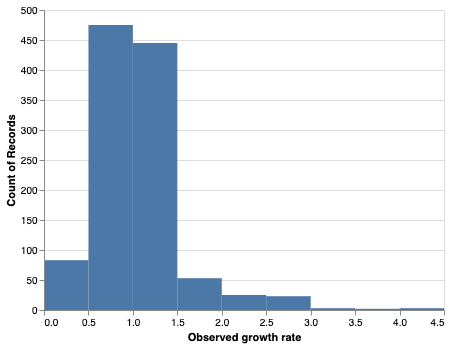

In [82]:
alt.Chart(initial_and_observed_clade_frequencies).mark_rect().encode(
    x=alt.X("observed_growth_rate:Q", bin=True, title="Observed growth rate"),
    y="count()"
)

## Find estimated future frequencies of large clades

Use the LBI model as an example, first.

In [87]:
clade_tip_estimated_frequencies = tips_to_clades.merge(
    forecasts,
    how="left",
    left_on=["timepoint", "tip"],
    right_on=["timepoint", "strain"]
).drop(columns=["depth", "strain", "fitness"])

In [89]:
clade_tip_estimated_frequencies = clade_tip_estimated_frequencies.fillna(0.0).copy()

In [90]:
clade_tip_estimated_frequencies.head()

,tip,clade_membership,timepoint,frequency,projected_frequency
0,sample_1016_4,6657900,2011-10-01,0.0,0.0
1,sample_1016_4,bf3c018,2011-10-01,0.0,0.0
2,sample_1016_4,root,2011-10-01,0.0,0.0
3,sample_1008_3,7a6369f,2011-10-01,0.0,0.0
4,sample_1008_3,bf3c018,2011-10-01,0.0,0.0


In [91]:
estimated_clade_frequencies = clade_tip_estimated_frequencies.groupby(
    ["timepoint", "clade_membership"]
).aggregate({"projected_frequency": "sum", "frequency": "sum"}).reset_index()

In [92]:
estimated_clade_frequencies.head()

,timepoint,clade_membership,projected_frequency,frequency
0,2011-10-01,0119439,1.064236e-05,0.017521
1,2011-10-01,0157622,1.823116e-08,0.000103
2,2011-10-01,0262285,9.679643e-05,0.086695
3,2011-10-01,02ccb89,0.000000e+00,0.000000
4,2011-10-01,03a2d3a,5.052533e-05,0.014059


In [93]:
complete_clade_frequencies = initial_and_observed_clade_frequencies.merge(
    estimated_clade_frequencies,
    on=["timepoint", "clade_membership"],
    suffixes=["", "_other"]
)

In [94]:
complete_clade_frequencies["estimated_growth_rate"] = (
    complete_clade_frequencies["projected_frequency"] / complete_clade_frequencies["frequency"]
)

In [95]:
complete_clade_frequencies["year"] = complete_clade_frequencies["timepoint"].dt.year

In [96]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate,projected_frequency,frequency_other,estimated_growth_rate,year
0,2018-10-01,0690f07,0.196406,0.178282,0.907722,0.002961,0.196406,0.015077,2018
1,2018-10-01,0783f23,0.999989,0.999998,1.000009,1.000000,0.999989,1.000011,2018
2,2018-10-01,0d82b51,0.999989,0.999998,1.000009,1.000000,0.999989,1.000011,2018
3,2018-10-01,0d8bb1e,0.963750,0.999998,1.037611,0.999985,0.963750,1.037598,2018
4,2018-10-01,1bce829,0.963750,0.999998,1.037611,0.999985,0.963750,1.037598,2018


In [97]:
complete_clade_frequencies.shape

(1112, 9)

In [98]:
min_growth_rate = 0
max_growth_rate = complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max() + 0.2

In [99]:
r, p = pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

In [100]:
r

0.4868804295375968

In [101]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(complete_clade_frequencies, True)

In [102]:
mcc

0.5776491649034684

In [103]:
confusion_matrix

{'tp': 445, 'tn': 432, 'fp': 126, 'fn': 109}

In [104]:
confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])

0.7793345008756567

In [105]:
confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])

0.7985212569316081

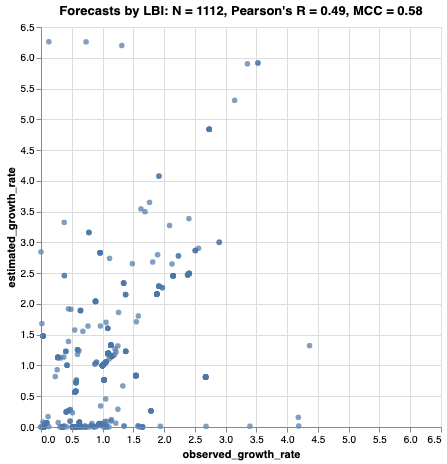

In [108]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("observed_growth_rate:Q", scale=alt.Scale(domain=(min_growth_rate, max_growth_rate))),
    alt.Y("estimated_growth_rate:Q", scale=alt.Scale(domain=(min_growth_rate, max_growth_rate))),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: N = %i, Pearson's R = %.2f, MCC = %.2f" % (complete_clade_frequencies.shape[0], r, mcc)
)

chart.save("forecast_growth_correlation_simulated_lbi.svg")
chart

In [107]:
complete_clade_frequencies.shape

(1112, 9)